In [2]:
import os
import json, yaml
import glob
from itertools import groupby

import numpy as np

import cv2
from PIL import Image
import skimage.io as io
from skimage import measure
import matplotlib.pyplot as plt

from collections import OrderedDict
from pycocotools import mask 
from pycocotools.coco import COCO

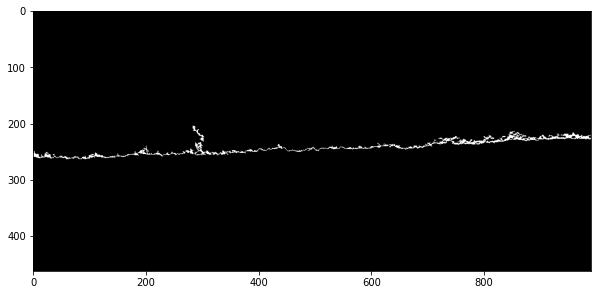

2581 3585


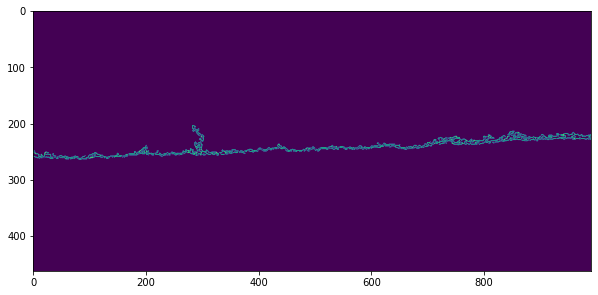

In [3]:
root_path = "/home/joo/Downloads/crack_dataset/"
top_folder = sorted(os.listdir(root_path))
number_of_folder = 0
mid_folder = "/masks/*" # /train/masks/*
bot_folder = ""


target = list(map(lambda x : x, sorted(glob.glob(root_path+top_folder[number_of_folder]+mid_folder+bot_folder))))

# json_file = {"images":[{"id":0,"file_name":"000001.jpg","height":height,"width":width}],
# "annotations":[{"image_id":str(1).zfill(5),"id":0, "category_id":0,"bbox":[]}],"categories":[]}

# img = 255 - img <-- 색반전
cnt = 0

for index, file in enumerate(target):
    # if index != 30: continue
    img = cv2.imread(file)
    img = np.where(img >= 245, 255, 0)
    img = np.uint8(img)

    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    plt.close()      
    
    # cv2.imwrite("./temp/temp_origin.png",img)

    edge = cv2.Canny(img,245,255)
    height, width = edge.shape
    
    cnt = 0
    cnt_origin = 0
    for he_num in range(height):
        for wi_num in range(width):
            if edge[he_num][wi_num] != 0:
                cnt = cnt + 1
            if img[he_num][wi_num].any() != 0:
                cnt_origin = cnt_origin + 1

    print(cnt,cnt_origin)

    plt.figure(figsize=(10,10))
    plt.imshow(edge)
    plt.show()
    plt.close()

    # cv2.imwrite("./temp/temp.png",edge)
    break


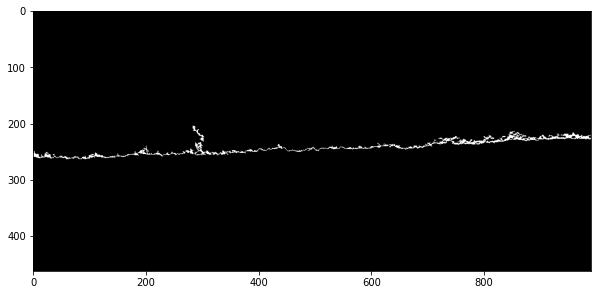

2581 3585


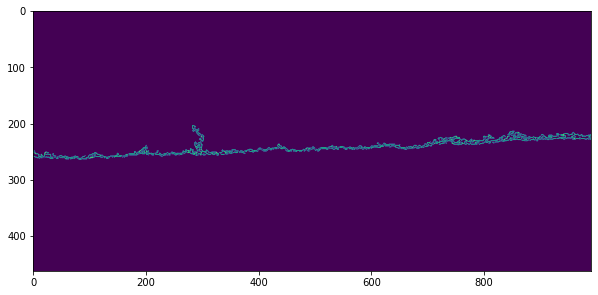

In [189]:
root_path = "/home/joo/Downloads/crack_dataset/"
top_folder = sorted(os.listdir(root_path))
number_of_folder = 0
mid_folder = "/masks/*" # /train/masks/*
bot_folder = ""


target = list(map(lambda x : x, sorted(glob.glob(root_path+top_folder[number_of_folder]+mid_folder+bot_folder))))

cnt = 0

for index, file in enumerate(target):
    # if index != 30: continue
    img = cv2.imread(file)
    img = np.where(img >= 245, 255, 0)
    img = np.uint8(img)

    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    plt.close()      
    
    # cv2.imwrite("./temp/temp_origin.png",img)

    edge = cv2.Canny(img,245,255)
    edge_list = np.where()

    plt.figure(figsize=(10,10))
    plt.imshow(edge)
    plt.show()
    plt.close()

    # cv2.imwrite("./temp/temp.png",edge)
    break


In [36]:
def get_annotation(mask_img, image=None):

    contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    segmentation = []
    for contour in contours:
        # Valid polygons have >= 6 coordinates (3 points)
        if contour.size >= 6:
            segmentation.append(contour.flatten().tolist())

    RLEs = mask.frPyObjects(segmentation, mask_img.shape[0], mask_img.shape[1])
    RLE = mask.merge(RLEs)
    # RLE = cocomask.encode(np.asfortranarray(mask))
    area = mask.area(RLE)
    [x, y, w, h] = cv2.boundingRect(mask_img)

    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.drawContours(image, contours, -1, (0,255,0), 1)
        cv2.rectangle(image,(x,y),(x+w,y+h), (255,0,0), 2)
        cv2.imshow("", image)
        cv2.waitKey(1)

    return segmentation, [x, y, w, h], area

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    # Fortran과 같은 순서로 인덱싱하여 배열(열 배열)
    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return rle    

class BytesEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, bytes):
            return obj.decode('utf-8')
        return json.JSONEncoder.default(self, obj)

# fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
# rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
# compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])


In [35]:
root_path = "/home/joo/Downloads/crack_dataset/"
top_folder = sorted(os.listdir(root_path))
number_of_folder = 0
mid_folder = "/masks/*" # /train/masks/*
bot_folder = ""

target_img = list(map(lambda x : x, sorted(glob.glob(root_path+top_folder[number_of_folder]+"/images/*"+bot_folder))))
target = list(map(lambda x : x, sorted(glob.glob(root_path+top_folder[number_of_folder]+mid_folder+bot_folder))))

num = 1

json_file = {"info":{"description":"KORAD 2022 Dataset","url":"https://www.sierrabase.co.kr/", 
"version":"1.0","year":2022,"contributor":"jylee","data_created":"2022/09/07"},
"images":[],"annotations":[],
"categories":[{"supercategory":"korad","id":1,"name":"concreteCrack"}]} 

for index, file in enumerate(target):
    temp = cv2.imread(file)
    height,width,_ = temp.shape
    mask_index = np.where(temp == (255,255,255),1,0)
    
    
    cnt = 1
    y_num = 0

    # print(int(target_img[index].split(".")[0][-5:]))
    # break
    json_file["images"].append({"id":int(target_img[index].split(".")[0][-5:]),
    "file_name":target_img[index].split(".")[0][-5:]+"."+target_img[index].split(".")[1],
    "height":height,"width":width})

    if len(mask_index[0]) < 1 :
        # background image 
        json_file["annotations"].append({"image_id":int(target_img[index].split(".")[0][-5:]),"id":num, "category_id":"","bbox":[],"area":"",
        "segmentation":[],"iscrowd":""})
        num = num + 1
        continue
    
    
    fortran_ground_truth_binary_mask = np.asfortranarray(mask_index)
    rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
    compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    area = mask.area(compressed_rle)
    bbox = mask.toBbox(compressed_rle)
    # break

    # # 가로축으로 위에서 부터 내려가며 훑는 방식
    # for i in range(0,len(mask_index[0]),3):
        
    #     # 3번 rule : 현재 x vector는 이전 값과 1차이가 나는가? 에 대한 if 처리
    #     if i == 0: 
    #         y_num = mask_index[0][i]
    #         segmentation.append(int(mask_index[0][i]))
    #         segmentation.append(int(mask_index[1][i]))
    #         continue
        
    #     # 2번 rule : 현재 x vector는 다음 값과 1차이가 나는가? 에 대한 except 처리
    #     try:
    #         if mask_index[0][i] == y_num and mask_index[1][i] + 1 == mask_index[1][i+3] and mask_index[1][i] == mask_index[1][i-3] + 1: continue
    #         else :
    #             segmentation.append(int(mask_index[0][i]))
    #             segmentation.append(int(mask_index[1][i]))
    #             y_num = mask_index[0][i]
    #             continue
    #     except IndexError:
    #         segmentation.append(int(mask_index[0][i]))
    #         segmentation.append(int(mask_index[1][i]))
    #         break

    json_file["annotations"].append({"image_id":int(target_img[index].split(".")[0][-5:]),"id":num, "category_id":1,
    # bbox : top-left-x, top-left-y, width, height
    "bbox":mask.toBbox(compressed_rle).tolist(),
    "area":int(mask.area(compressed_rle)),"segmentation":compressed_rle,"iscrowd":0})

    num = num + 1
    break

# print(json_file)

# with open("temp.json",'w', encoding='utf-8') as f:
#     json.dump(json_file, f)

TypeError: Object of type 'bytes' is not JSON serializable

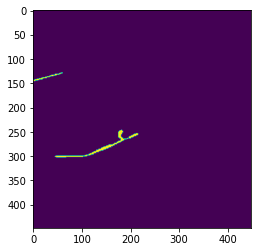

37


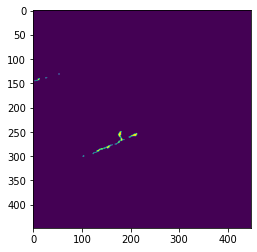

In [96]:
a = cv2.imread("/home/joo/Downloads/crack_dataset/3_Conglomerate_Concrete_Crack_Detection/train/masks/01089_GT.jpg", 0)
b = a.copy()

plt.imshow(a)
plt.show()
plt.close()

seg, bbox, area = get_annotation(mask_img=a)

# print(seg, bbox, area)

contours, _ = cv2.findContours(b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

for contour in contours:
    b = cv2.drawContours(b, [contour], -1, (0,0,255),2)
plt.imshow(b)
plt.show()
plt.close()

In [3]:


# test_list_1 = np.array([0, 0, 1, 1, 1, 0, 1])

test_list_1 = np.array([[0, 0, 1, 1, 1, 0, 1],
                        [0, 0, 1, 1, 1, 0, 1],
                        [0, 0, 1, 1, 1, 0, 1]])
# test_list_2 = np.array([1, 1, 1, 1, 1, 1, 0])

print(binary_mask_to_rle(test_list_1))
# print(binary_mask_to_rle(test_list_2))

{'counts': [6, 9, 3, 3], 'size': [3, 7]}


In [12]:
ground_truth_binary_mask = np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=np.uint8)

fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)

In [13]:
rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
print(rle)

{'counts': [6, 1, 40, 4, 5, 4, 5, 4, 21], 'size': [9, 10]}


In [14]:
compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
print(compressed_rle['counts'])
print(type(compressed_rle))
w = mask.decode(compressed_rle)

b'61X13mN000`0'
<class 'dict'>


[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


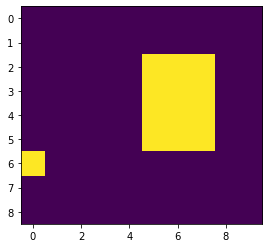

In [15]:
print(w)

plt.imshow(w)

In [138]:
coco = COCO('temp.json')

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
COCO categories: 
ConcreteCrack

COCO supercategories: 
korad


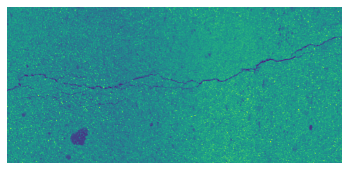

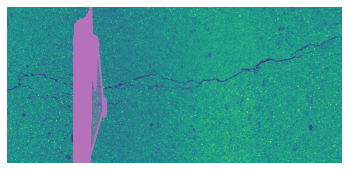

In [204]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['concreteCrack'])
imgIds = coco.getImgIds(catIds=catIds )
imgIds = coco.getImgIds(imgIds = [7])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(root_path+top_folder[number_of_folder]+"/images/"+img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [201]:
from shapely.geometry import Point, LineString, Polygon

# Create Point geometric object(s) with coordinates
point1 = Point(2.2, 4.2)
point2 = Point(7.2, -25.1)
point3 = Point(9.26, -2.456)
point3D = Point(9.26, -2.456, 0.57)

print(point1)
print(point3D)
type(point1)

POINT (2.2 4.2)
POINT Z (9.26 -2.456 0.57)


shapely.geometry.point.Point

In [202]:
# Create a LineString from our Point objects
line = LineString([point1, point2, point3])

# It is also possible to produce the same outcome using coordinate tuples
line2 = LineString([(2.2, 4.2), (7.2, -25.1), (9.26, -2.456)])

# Check if lines are identical
line == line2 

True

True